In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import math

### Utils


In [2]:
def stack_images(files, type, titles = None):
    # Load images
    images = [
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for f in files
        if (img := cv2.imread(f)) is not None and len(img.shape) > 2
    ]


    fig, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5))

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.axis("off")
        if titles is not None:
            ax.set_title(title, fontsize=14)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  # padding between images
    plt.savefig(f"{type}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [3]:
input_images = []

flowers_image_path = "images\\flowers.png"
flowers_image = cv2.imread(flowers_image_path)
moon_noisy_image_path = "images\moon_noisy.png"
moon_noisy_image = cv2.imread(moon_noisy_image_path)
sharp_image_path = "images\sharp.png"
sharp_image = cv2.imread(sharp_image_path)
study_image_path = "images\study.png"
study_image = cv2.imread(study_image_path)
cheme_image_path = "images\\cheme.png"
cheme_image = cv2.imread(cheme_image_path)
flying_image_path = "images\\flying.png"
flying_image = cv2.imread(flying_image_path)
trees_image_path = "images\\trees.png"
trees_image = cv2.imread(trees_image_path)
fox_image_path = "images\\fox.png"
fox_image = cv2.imread(fox_image_path)
tees_image_path = "images\\tees.png"
tees_image = cv2.imread(tees_image_path)
# input_images.append()

### A1Q1 Histogram Computation

In [4]:
class A1Q1:

    def __init__(self, img, img_name = "", K = 256):
        self.img = img
        self.img_name = img_name
        if (len(self.img.shape) == 3):
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.h, self.w = self.img.shape
        self.freq = np.array(0)
        self.probabilities = np.array(0)
        self.K = K

    def intensity_probabilities(self):
        freq = self.histogram()
        self.probabilities = freq / np.sum(freq)

    def histogram(self):
        freq = np.zeros(256)
        if self.img is not None:
            h, w = self.h, self.w
            for i in range(h):
                for j in range(w):
                    freq[self.img[i, j]] += 1

        self.freq = freq
        return freq
    
    def plot_histogram(self, m=0):
        freq = self.histogram()
        plt.figure(figsize=(6, 4))
        plt.plot(freq, label=f"m={m}")
        plt.xlabel("Intensities")
        plt.ylabel("Frequencies")
        plt.savefig(f"{self.img_name}_histogram.png", bbox_inches="tight")
        plt.close() 

    def average_intensity_from_histogram(self):
        avg_intensity = 0
        for i, f in enumerate(self.freq):
            avg_intensity += i * f
        h, w = self.h, self.w
        avg_intensity /= (h * w)
        return avg_intensity
    
    def average_intensity_from_image(self):
        return np.mean(self.img)
    
    def is_intensity_correct_from_histogram(self):
        return self.average_intensity_from_histogram() == self.average_intensity_from_image()       

        

### A1Q2. Otsu’s Binarization

In [5]:
class A1Q2(A1Q1):
    def __init__(self, img, offset = 0):
        super().__init__(self.add_offset(img, offset=offset))
        self.intensity_probabilities()

    def add_offset(self, img, offset = 0):
        offset_image = np.clip(img.astype(np.int16) + offset , 0, 255)            
        return offset_image.astype(np.uint8)


    def class_probabilities(self, t):
        prob = self.probabilities
        class_0_probability = np.sum(prob[:t + 1])
        class_1_probability = np.sum(prob[t + 1:])
        return class_0_probability, class_1_probability
    
    def class_means(self, t, w0, w1):
        prob = self.probabilities
        class_0_mean =  np.sum(np.array([k*prob[k] for k in range(t + 1)])) / w0
        class_1_mean =  np.sum(np.array([k*prob[k] for k in range(t + 1, len(prob))])) / w1
        return class_0_mean, class_1_mean
    
    def within_class_variance(self, t):
        prob = self.probabilities
        w0, w1 = self.class_probabilities(t)
        if (w0 == 0 or w1 == 0): return None
        mu0, mu1 = self.class_means(t, w0, w1)
        var0_sq = np.sum(np.array([(((k - mu0)**2) * prob[k]) for k in range(t + 1)])) / w0
        var1_sq = np.sum(np.array([(((k - mu1)**2) * prob[k]) for k in range(t + 1, len(prob))])) / w1
        var_sq = w0 * var0_sq + w1 * var1_sq
        return var_sq

    def between_class_variance(self, t):
        w0, w1 = self.class_probabilities(t)
        if (w0 == 0 or w1 == 0): return None
        mu0, mu1 = self.class_means(t, w0, w1)
        between_class_variance = w0 * w1 * ((mu0 - mu1) ** 2)
        return between_class_variance



    def minimize_within_class_variance(self):
        t_opt, min_within_class_variance = 0, math.inf
        for t in range(self.K):
            var_sq = self.within_class_variance(t)
            if (var_sq is not None and var_sq < min_within_class_variance):
                min_within_class_variance = var_sq
                t_opt = t
        
        return t_opt, round(min_within_class_variance, 2)

    def maximize_between_class_variance(self):
        t_opt, max_between_class_variance = 0, 0
        for t in range(self.K):
            between_class_variance = self.between_class_variance(t)
            if (between_class_variance is not None and between_class_variance > max_between_class_variance):
                t_opt = t
                max_between_class_variance = between_class_variance
        return t_opt, max_between_class_variance
    
    def binarize(self, title = None, t_opt = None):
        if t_opt is None:
            t_opt, min_within_class_variance = self.minimize_within_class_variance()
        binarized_image = np.where(self.img > t_opt, 255, 0).astype(np.uint8)
        if title is not None:
            success = cv2.imwrite(f"{title}.png", binarized_image)
        
        return binarized_image



        

### A2Q1. Spatial Filtering and Binarisation

In [6]:
class A2Q1:
    def __init__(self, image):
        self.image = image
        pass

    def create_filter(self, m):
        return (1 / (m) ** 2) * np.full((m, m), 1)

    def convolution(self, m, name):
        box_filter = self.create_filter(m)
        convolved_image = cv2.filter2D(self.image, -1, box_filter)
        cv2.imwrite(f'convolved_{name}_with_kernel_size_{m}.jpg', convolved_image)
        return convolved_image



### A2Q2. Scaling and Rotation with Interpolation

In [12]:
class A2Q2:
    def __init__(self):
        pass

    def bilinear_interpolation(self, img, y, x):
        h, w = img.shape[:2]
        x0, y0 = int(np.floor(x)), int(np.floor(y))
        dx, dy = x - x0, y - y0
        x1, y1 = min(x0 + 1, w - 1), min(y0 + 1, h - 1)

        Q11 = img[y0, x0]  
        Q21 = img[y0, x1]  
        Q12 = img[y1, x0]  
        Q22 = img[y1, x1]  

        interpolated = (Q11 * (1 - dx) * (1 - dy) +
                        Q21 * dx * (1 - dy) +
                        Q12 * (1 - dx) * dy +
                        Q22 * dx * dy)

        return interpolated


    def rotate_image(self, image, theta_degrees):
        theta_rad = theta_degrees * np.pi / 180

        h, w = image.shape[:2]
        h_c, w_c = h // 2, w // 2

        rotation_matrix = np.array([[np.cos(theta_rad), - np.sin(theta_rad)],
                                    [np.sin(theta_rad), np.cos(theta_rad)]])
        
        inv_rotation_matrix = np.linalg.inv(rotation_matrix)

        corners = np.array([
                        [0, 0],
                        [0, h],
                        [w, 0],
                        [w, h]
                    ])
        
        shifted = corners - np.array([w_c, h_c])
        rotated_corners = shifted @ rotation_matrix.T
        min_coords = rotated_corners.min(axis=0)
        max_coords = rotated_corners.max(axis=0)

        new_w = int(np.ceil(max_coords[0] - min_coords[0]))
        new_h = int(np.ceil(max_coords[1] - min_coords[1]))

        rotated_image = np.zeros((new_h, new_w, 3), dtype=image.dtype)

        new_cx, new_cy = new_w / 2, new_h / 2

        for i in range(new_h):
            for j in range(new_w):
                old_coord = inv_rotation_matrix @ np.array([i - new_cx, j - new_cy])
                i_old, j_old = old_coord[0] + h_c, old_coord[1] + w_c

                if i_old < 0 or j_old < 0 or i_old >= h or j_old >= w:
                    rotated_image[i, j] = [0, 0, 0]
                else:
                    rotated_image[i, j] = self.bilinear_interpolation(image, i_old, j_old)

        return rotated_image

    def upsampling(self, img, factor = 1):
        h, w = img.shape[:2]
        new_h, new_w = h * factor, w * factor
        upsampled = np.zeros((new_h, new_w, img.shape[2]), dtype=img.dtype)
        for i in range(new_h):
            for j in range(new_w):
                orig_y = j / factor
                orig_x = i / factor
                upsampled[i, j] = self.bilinear_interpolation(img, orig_x, orig_y)

        return upsampled
        


### A2Q3. Image Sharpening Concept

In [ ]:
class A2Q3:
    def __init__(self, img, kernel_size=5, sigma=1.0):
        self.img = img.astype(np.float32)
        self.kernel = self.gaussian_kernel(kernel_size, sigma)  

    def gaussian_kernel(self, size, sigma):
        ax = np.linspace(-(size // 2), size // 2, size)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        return kernel / np.sum(kernel)

    def sharpen(self, p):
        p *= 10 # p is scaled by 10
        blurred = cv2.filter2D(self.img, -1, self.kernel)
        sharpened = self.img + p * (self.img - blurred)

        return np.clip(sharpened, 0, 255).astype(np.uint8)

   

Threshold on Minimizing the Within Class Variance is: 127, with within class variance of: 169.61
Threshold on Minimizing the Within Class Variance is: 121, with within class variance of: 287.25
Threshold on Minimizing the Within Class Variance is: 91, with within class variance of: 270.25


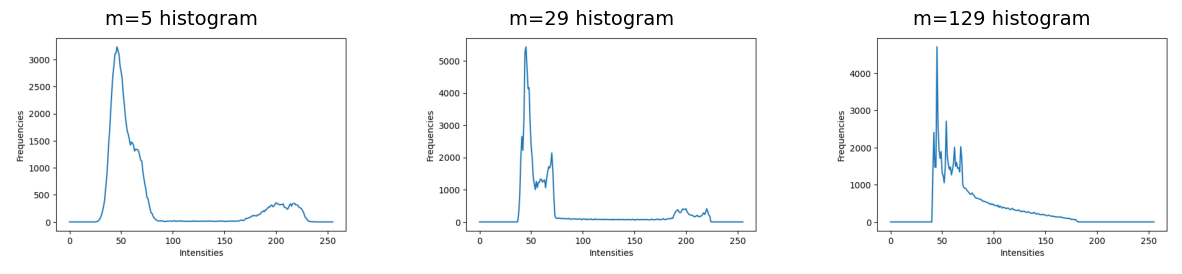

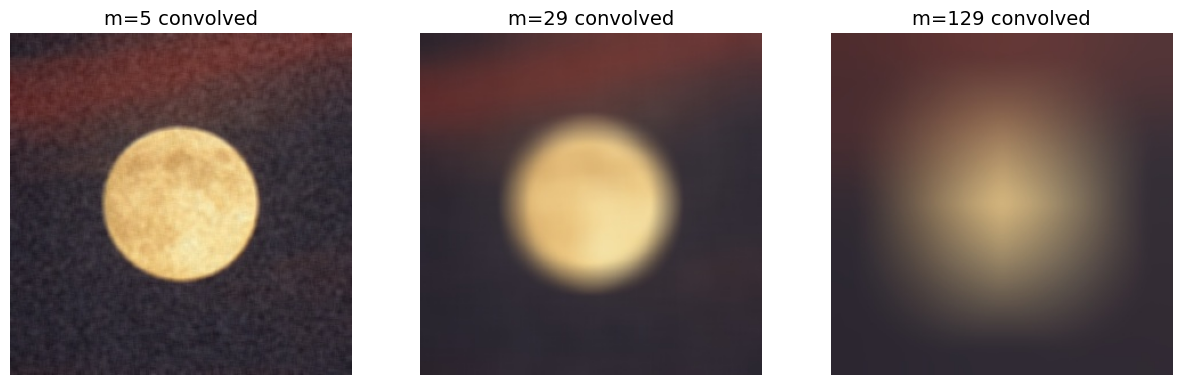

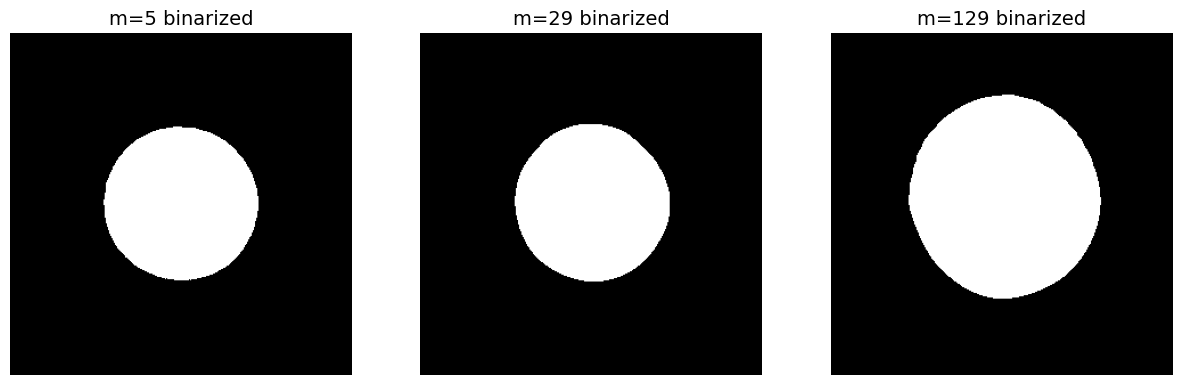

In [9]:
name = "moon_noisy_image"
a2q1 = A2Q1(moon_noisy_image)
M = [5, 29, 129]
binarized_images_files, histogram_files, convolved_images_files = [], [], []
binarized_images_titles, histogram_titles, convolved_image_titles = [], [], []

for m in M:
    convolved_image =  a2q1.convolution(m, name)
    convolved_images_files.append(f"convolved_{name}_with_kernel_size_{m}.jpg")
    convolved_image_titles.append(f"m={m} convolved")

    a1q1 = A1Q1(convolved_image, f"{name}_convolved_{m}")
    a1q1.plot_histogram(m)
    
    histogram_files.append(f"{name}_convolved_{m}_histogram.png")
    histogram_titles.append(f"m={m} histogram")
    
    q2_a = A1Q2(convolved_image)
    threshold, within_class_variance = q2_a.minimize_within_class_variance()
    q2_a.binarize(f"Binarized Moon Image Convolved with {m}-sized box filter")
    binarized_images_files.append(f"Binarized Moon Image Convolved with {m}-sized box filter.png")
    binarized_images_titles.append(f"m={m} binarized")
    print(f"Threshold on Minimizing the Within Class Variance is: {threshold}, with within class variance of: {within_class_variance}" )

stack_images(histogram_files, type="Histograms", titles=histogram_titles)
stack_images(convolved_images_files, type="Convolved Images", titles=convolved_image_titles)
stack_images(binarized_images_files, type = "Binarized Images", titles=binarized_images_titles)


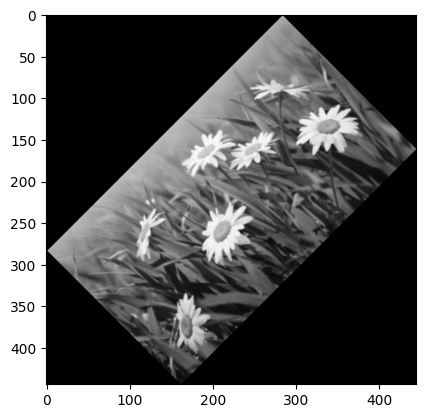

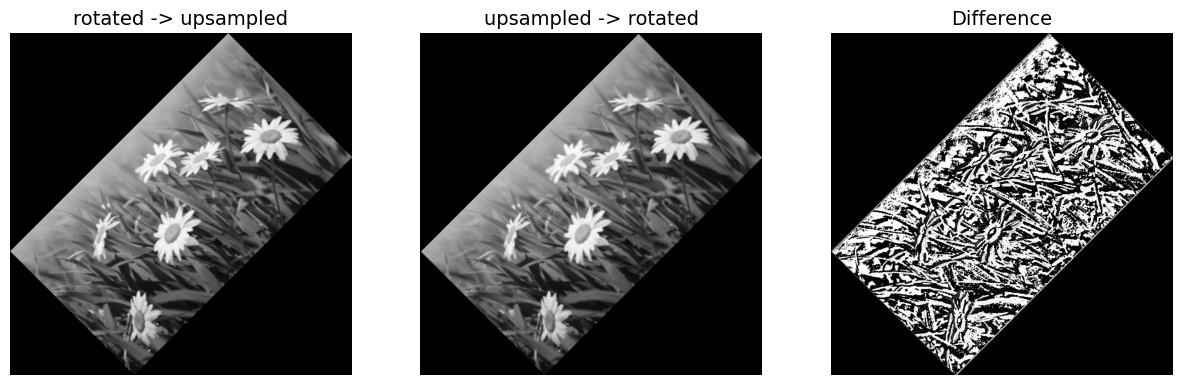

In [10]:
a2q2 = A2Q2()
outputs, titles = [], []

upsampled_flower_image = a2q2.upsampling(flowers_image, 2)
rotated_upsampled_flower_image = a2q2.rotate_image(upsampled_flower_image, 45)
cv2.imwrite("rotated_upsampled_flower_image.png", rotated_upsampled_flower_image)
titles.append("rotated -> upsampled")

a2q2 = A2Q2()
rotated_flower_image = a2q2.rotate_image(flowers_image, 45)
upsampled_rotated_flower_image = a2q2.upsampling(rotated_flower_image, 2)
cv2.imwrite("upsampled_rotated_flower_image.png", upsampled_rotated_flower_image)
titles.append("upsampled -> rotated")

diff = rotated_upsampled_flower_image[0:887, 0:887] - upsampled_rotated_flower_image[0:887, 0:887]
cv2.imwrite("diff.png", diff)
titles.append("Difference")

outputs.append("rotated_upsampled_flower_image.png")
outputs.append("upsampled_rotated_flower_image.png")
outputs.append("diff.png")

stack_images(outputs, type="Problem_2", titles=titles)


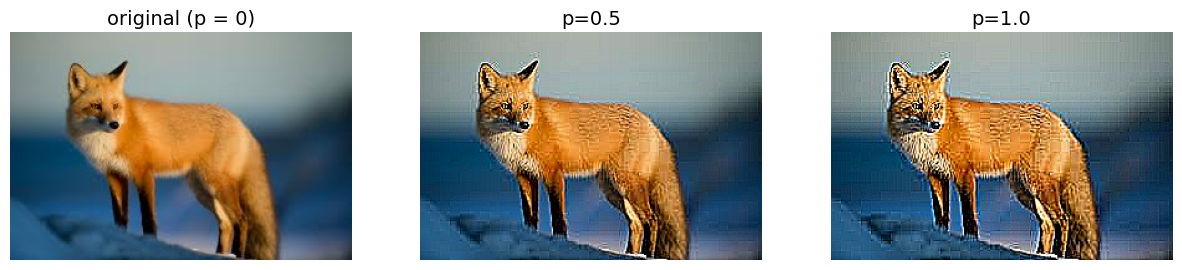

In [11]:
name = "fox_image"
a2q3 = A2Q3(fox_image, 3, 2)
titles, p_value, images = [], [], []
for p in np.arange(0.0, 1.01, 0.5):
    sharpened_image = a2q3.sharpen(p)
    titles.append(f"p={p}" if p else "original (p = 0)")
    p_value.append(p)
    images.append(f"sharpened_{name}_p = {p}.png")
    cv2.imwrite(f"sharpened_{name}_p = {p}.png", sharpened_image)
    cv2.waitKey(0)

stack_images(images, "sharpened_image", titles)